## Part 1: Libraries Import

### 1.1 Libraries for Data Analysis and Visualization

In [1]:
# Data Analysis and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
import warnings
# To keep the output clean from warnings, can be removed after demonstration.
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # Display all columns
sns.set_theme(style="whitegrid")

### 1.2 Libraries for NLP and Modeling

In [2]:
# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Word Cloud
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# ML Models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Baseline Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Transformers (BERT)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

# Download NLTK resources (silent)
nltk_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']
for resource in nltk_resources:
    nltk.download(resource, quiet=True)

print("NLTK resources ready!")
print("All libraries imported successfully!")

NLTK resources ready!
All libraries imported successfully!


### 1.3 Reading Data

In [3]:
df = pd.read_csv('../data/customer_sentiment.csv')
# Display basic information
print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"\nData Attributes:\n{list(df.columns)}")

Shape: 25000 rows x 13 columns

Data Attributes:
['customer_id', 'gender', 'age_group', 'region', 'product_category', 'purchase_channel', 'platform', 'customer_rating', 'review_text', 'sentiment', 'response_time_hours', 'issue_resolved', 'complaint_registered']


## Part 2: Exploratory Data Analysis (EDA)

### 2.1 EDA - Part 1: Basic Exploration and Summary Statistics
1. Display first 5 rows of the dataset
2. Display dataset information
3. Display basic statistics for numerical columns
4. Check for missing values

In [4]:
# data_overview: List of tuples containing (section title, display function)
data_overview = [
    ("FIRST 5 ROWS", lambda: display(df.head())),
    ("DATASET INFO", lambda: df.info()),
    ("STATISTICS SUMMARY", lambda: display(df.describe())),
    ("MISSING VALUES", lambda: print(df.isnull().sum()[df.isnull().sum() > 0]
                                     if df.isnull().any().any() else "No missing values found."))]
# Display each section with numbered headers
# 1 is tuple's elements index, to start the headers number from 1
for i, (title, func) in enumerate(data_overview, 1):
    print(f"\n{i} - {title}:")
    # call the lambda function to display the content
    func()


1 - FIRST 5 ROWS:


,customer_id,gender,age_group,region,product_category,purchase_channel,platform,customer_rating,review_text,sentiment,response_time_hours,issue_resolved,complaint_registered
0,1,male,60+,north,automobile,online,flipkart,1,very disappointed with the quality.,negative,46,yes,yes
1,2,other,46-60,central,books,online,swiggy instamart,5,fast delivery and great packaging.,positive,5,yes,no
2,3,female,36-45,east,sports,online,facebook marketplace,1,very disappointed with the quality.,negative,38,yes,yes
3,4,female,18-25,central,groceries,online,zepto,2,product stopped working after few days.,negative,16,yes,yes
4,5,female,18-25,east,electronics,online,croma,3,neutral about the quality.,neutral,15,yes,no



2 - DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_id           25000 non-null  int64 
 1   gender                25000 non-null  object
 2   age_group             25000 non-null  object
 3   region                25000 non-null  object
 4   product_category      25000 non-null  object
 5   purchase_channel      25000 non-null  object
 6   platform              25000 non-null  object
 7   customer_rating       25000 non-null  int64 
 8   review_text           25000 non-null  object
 9   sentiment             25000 non-null  object
 10  response_time_hours   25000 non-null  int64 
 11  issue_resolved        25000 non-null  object
 12  complaint_registered  25000 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.5+ MB

3 - STATISTICS SUMMARY:


,customer_id,customer_rating,response_time_hours
count,25000.000000,25000.000000,25000.000000
mean,12500.500000,3.002480,36.023480
std,7217.022701,1.404647,20.597941
min,1.000000,1.000000,1.000000
25%,6250.750000,2.000000,18.000000
50%,12500.500000,3.000000,36.000000
75%,18750.250000,4.000000,54.000000
max,25000.000000,5.000000,71.000000



4 - MISSING VALUES:
No missing values found.


### 2.2 Basic Data Quality Checks

In [5]:
# Function to check for duplicates
def check_duplicates(dataframe):
    duplicate_count = dataframe.duplicated().sum()
    print(f"Total Duplicates: {duplicate_count}")
    print(f"{'Warnings: Duplicates found!' if duplicate_count > 0 else 'No duplicates found.'}")

# function to check unique values in categorical columns
def check_unique_values(dataframe):
    categorical_attrs = dataframe.select_dtypes(include=['object', 'category']).columns
    for cols in categorical_attrs:
        print(f"\nColumn:[{cols}] has {dataframe[cols].nunique()} unique values.")
        print(f"Values: {list(dataframe[cols].unique())}")

# Sum of sentiment distribution. The sentiment col. will be ignored during modeling,
# but we decided to keep it for EDA purposes and use it later for performance evaluation.
def sentiment_distribution(dataframe):
    """ Display sentiment distribution """
    print(dataframe['sentiment'].value_counts())
    print("\nPercentages:",
          dataframe['sentiment'].value_counts(normalize=True).round(3) * 100)

# List of a tuples to hold the checks to be performed
data_quality_checks = [
    ("DUPLICATE CHECK", check_duplicates),
    ("UNIQUE VALUES IN CATEGORICAL COLUMNS", check_unique_values),
    ("CUSTOMER RATING DISTRIBUTION", lambda dataframe:print(dataframe['customer_rating'].value_counts().sort_index())),
    ("SENTIMENT DISTRIBUTION", sentiment_distribution)]

# Perform each data quality check with numbered headers
for i , (check_title, check_func) in enumerate(data_quality_checks, 1):
    print(f"\n{i} - {check_title}:")
    check_func(df)


1 - DUPLICATE CHECK:
Total Duplicates: 0
No duplicates found.

2 - UNIQUE VALUES IN CATEGORICAL COLUMNS:

Column:[gender] has 3 unique values.
Values: ['male', 'other', 'female']

Column:[age_group] has 5 unique values.
Values: ['60+', '46-60', '36-45', '18-25', '26-35']

Column:[region] has 5 unique values.
Values: ['north', 'central', 'east', 'south', 'west']

Column:[product_category] has 9 unique values.
Values: ['automobile', 'books', 'sports', 'groceries', 'electronics', 'travel', 'fashion', 'home & kitchen', 'beauty']

Column:[purchase_channel] has 1 unique values.
Values: ['online']

Column:[platform] has 20 unique values.
Values: ['flipkart', 'swiggy instamart', 'facebook marketplace', 'zepto', 'croma', 'amazon', 'shopclues', 'tata cliq', 'snapdeal', 'paytm mall', 'ajio', 'myntra', 'nykaa', 'reliance digital', 'meesho', 'bigbasket', 'lenskart', 'jiomart', 'others', 'boat']

Column:[review_text] has 15 unique values.
Values: ['very disappointed with the quality.', 'fast delive

### 2.3 EDA - Part 2: Visualizations
1. Rating Profile
2. Rating by Segments
3. Response Time by Rating

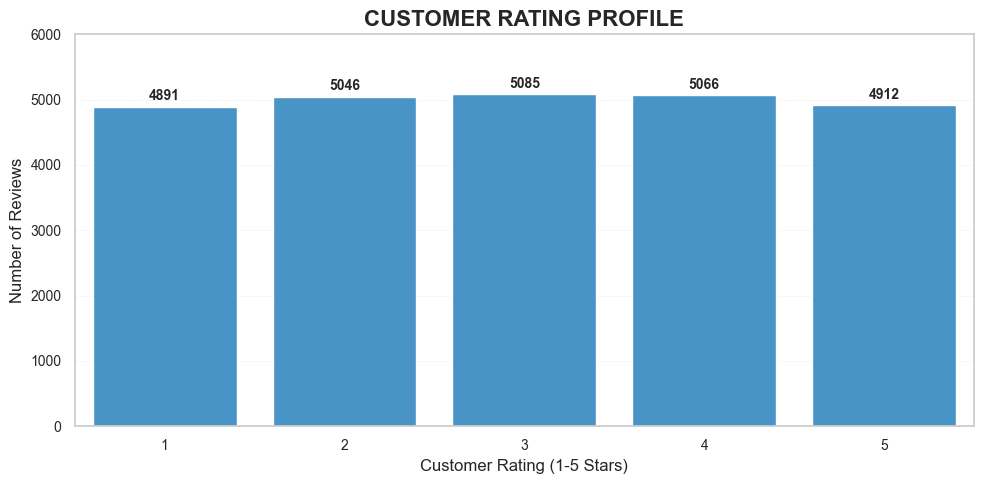

In [6]:
# Baseline - Customer Rating Profile
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='customer_rating', color='#3498db')
plt.title('CUSTOMER RATING PROFILE', fontsize=16, fontweight='bold')
plt.xlabel('Customer Rating (1-5 Stars)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.ylim(0, 6000)  # Extend upper limit for y_axis for better visibility
plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_axisbelow(True)

# Add value labels on top of bars
rating_counts = df['customer_rating'].value_counts().sort_index()
for i, v in enumerate(rating_counts.to_list()):
    plt.text(i, v + 100, str(v), ha='center', fontweight
              ='bold', fontsize=10)
plt.tight_layout()
plt.show()

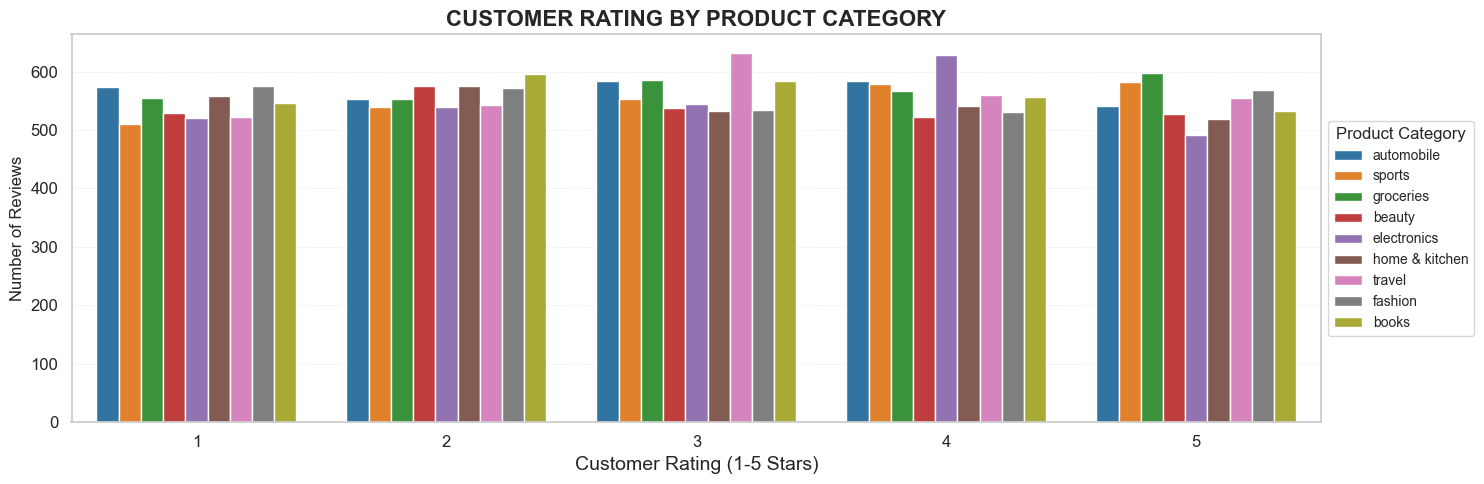

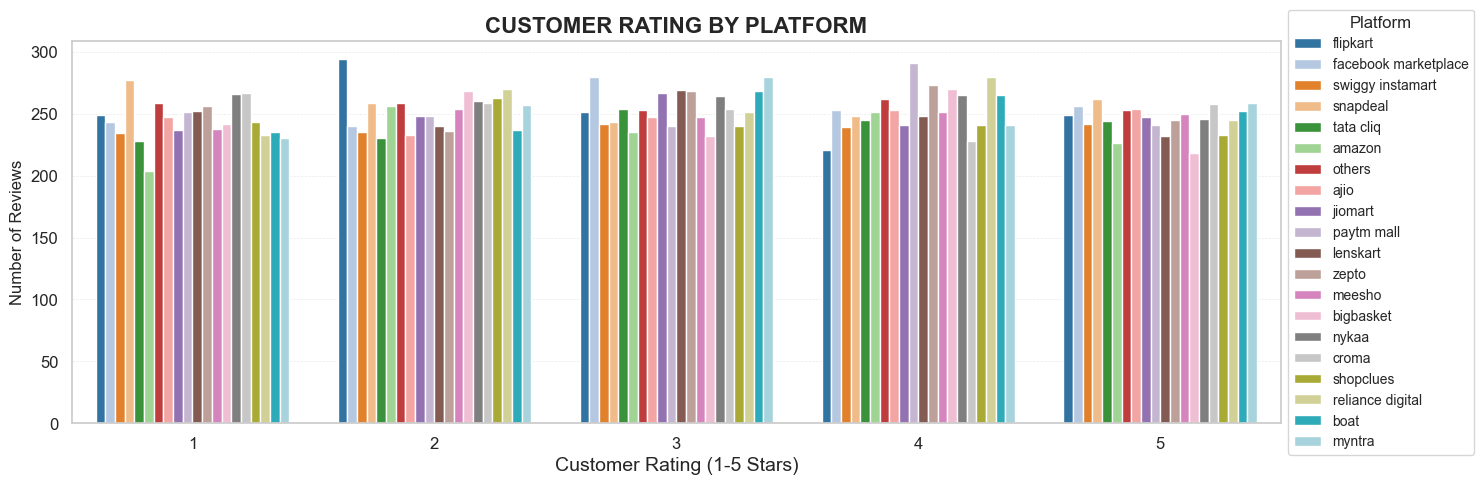

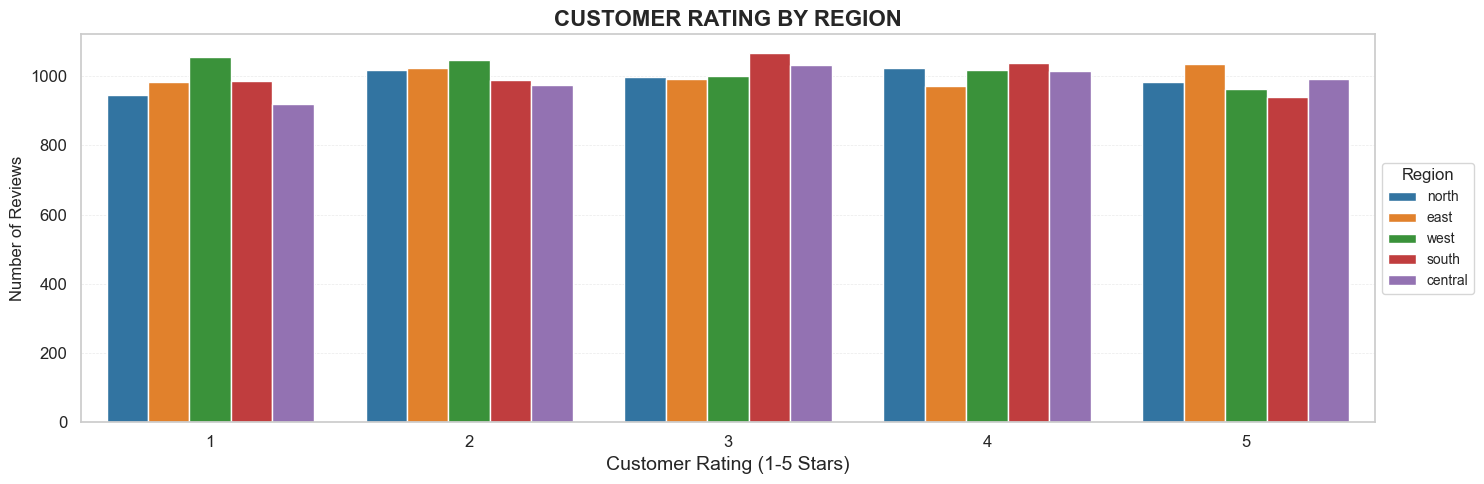

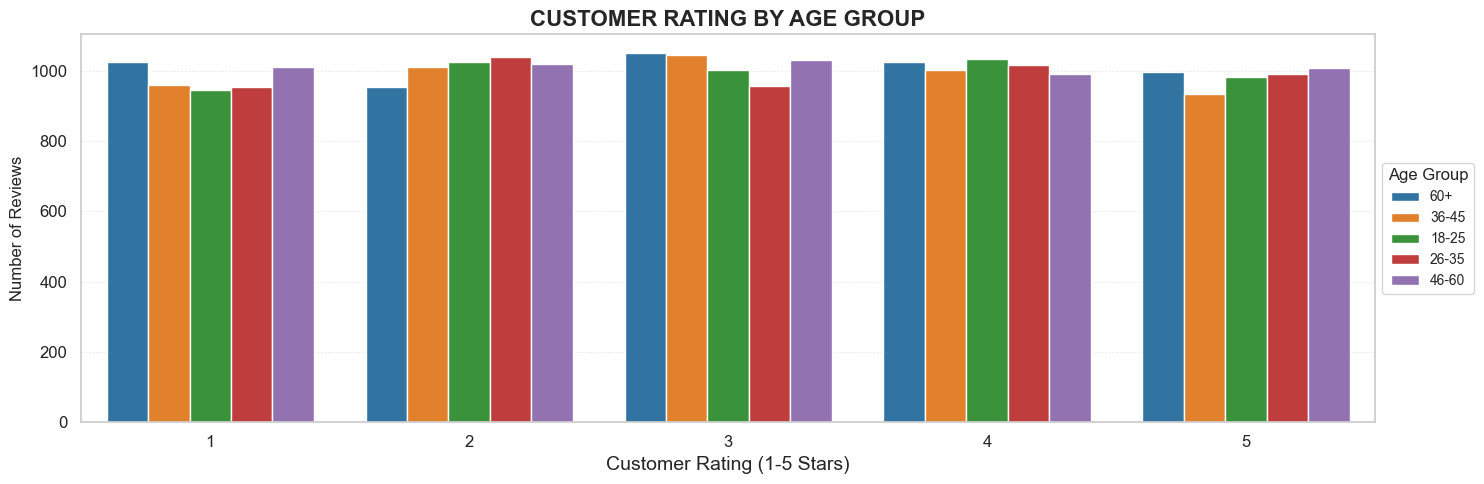

In [7]:
# Rating by Segments (product_category, platform, region, age_group)
segment_attrs = ['product_category', 'platform', 'region', 'age_group']

for attr in segment_attrs:
    # Count unique values for this attribute
    n_categories = df[attr].nunique()

    # Generate enough distinct colors
    if n_categories <= 10:
        palette = sns.color_palette('tab10', n_categories)
    elif n_categories <= 20:
        palette = sns.color_palette('tab20', n_categories)
    else:
        # For 20+ categories, use husl which generates unlimited distinct colors
        palette = sns.color_palette('husl', n_categories)

    plt.figure(figsize=(15, 5))
    sns.countplot(data=df, x='customer_rating', hue=attr, palette=palette, order=[1, 2, 3, 4, 5])
    plt.title(f"CUSTOMER RATING BY {attr.upper().replace('_',' ')}", fontsize=16, fontweight='bold')
    plt.xlabel('Customer Rating (1-5 Stars)', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.grid(axis='y', alpha=0.4, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().set_axisbelow(True)
    plt.legend(title=attr.replace('_', ' ').title(), fontsize=10, title_fontsize=12,
               loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

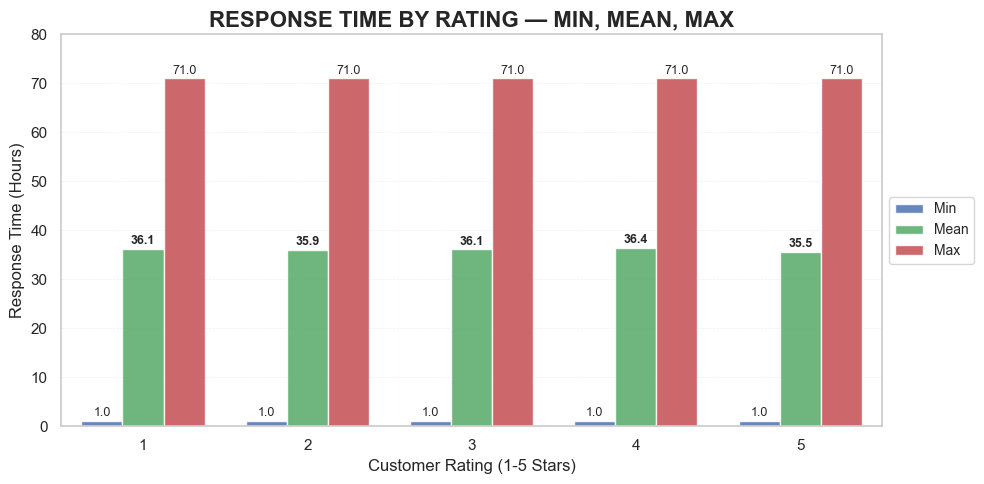

In [8]:
# Response Time Statistics by Rating
stats = df.groupby('customer_rating')['response_time_hours'].agg(['min', 'mean', 'max'])

fig, ax = plt.subplots(figsize=(10, 5))

# Bars configuration
bar_config = [
    (-0.25, 'min', 'Min'), # Left bar
    (0, 'mean', 'Mean'),   # Center bar
    (0.25, 'max', 'Max')   # Right bar
]
# Colors for the bars
colors = sns.color_palette('deep6', 3)
x = np.arange(1, 6)

# Bars and annotations
for (offset, col, label), color in zip(bar_config, colors):
    values = stats[col].to_list()
    ax.bar(x + offset, values, width=0.25, label=label, color=color, alpha=0.85)

    # Add value labels
    for i, v in enumerate(values):
        weight = 'bold' if col == 'mean' else 'normal'
        ax.text(x[i] + offset, v + 1, f'{v:.1f}', ha='center',
                fontsize=9, fontweight=weight)
# Axes and grid configuration
ax.set_title('RESPONSE TIME BY RATING — MIN, MEAN, MAX', fontsize=16, fontweight='bold')
ax.set_xlabel('Customer Rating (1-5 Stars)', fontsize=12)
ax.set_ylabel('Response Time (Hours)', fontsize=12)
ax.set_xticks(x)
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 80)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.grid(axis='x', visible=False)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

## Part 3: Text Preprocessing

#### Preprocessing Functions

In [9]:
# NLTK Lemmatizer Initialization
lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def clean_text(reviews):
    """ Clean and Normalize review text """
    # Lowercase
    reviews = reviews.lower()
    # Remove URLs, we don't really have in our dataset, but just in case
    reviews = re.sub(r'http\S+|www\S+|https\S+', '', reviews, flags=re.MULTILINE)
    # Remove HTML tags, we don't really have in our dataset, but just in case
    reviews = re.sub(r'<.*?>', '', reviews)
    # remove email addresses, we don't really have in our dataset, but just in case
    reviews = re.sub(r'\S+@\S+', '', reviews)
    # Remove punctuation
    reviews = reviews.translate(str.maketrans('', '', string.punctuation))
    # Remove white spaces, newlines, tabs
    reviews = re.sub(r'\s+', ' ', reviews).strip()
    return reviews

# Tokenization
def tokenize_text(reviews):
    """Tokenize text into words."""
    return word_tokenize(reviews)

# Remove stopwords
def remove_stopwords(tokens):
    """Remove stopwords from token list."""
    stop_words = set(stopwords.words('english'))
    # Negations: include both original and post-punctuation-removal forms
    negations = {
        "not", "no", "never", "none", "nobody", "nothing", "neither", "nor",
        "nt", "dont", "doesnt", "didnt", "wont", "wouldnt", "couldnt",
        "shouldnt", "cant", "cannot", "isnt", "arent", "wasnt", "werent",
        "hasnt", "havent", "hadnt", "without", "barely", "hardly", "scarcely"
    }
    # Intensifiers for critical sentiment words
    intensifiers = {
        "very", "really", "extremely", "absolutely", "completely", "totally",
        "highly", "so", "too", "most", "more", "less", "least", "much"
    }
    preserve_words = negations | intensifiers
    return [word for word in tokens if word not in stop_words or word in preserve_words]

# Lemmatization
def lemmatize_tokens(tokens):
    """Lemmatize tokens using NLTK WordNetLemmatizer."""
    return [lemmatizer.lemmatize(token) for token in tokens]

# Full Preprocessing Pipeline
def preprocess_text(reviews):
    """Full text preprocessing pipeline."""
    reviews = clean_text(reviews)
    tokens = tokenize_text(reviews)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)

print("Text preprocessing functions ready!")

Text preprocessing functions ready!


#### Create Sentiment Labels

In [10]:
# Map customer ratings to sentiment labels
def classify_sentiment(rating):
    """Classify sentiment based on customer rating."""
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
# Apply sentiment classification
df['sentiment_label'] = df['customer_rating'].apply(classify_sentiment)

# Display sentiment label distribution after mapping to verify
print("\nSentiment Label Distribution After Mapping from (ratings):")
print(df['sentiment_label'].value_counts())
print("\nPercentages:",)
print((df['sentiment_label'].value_counts(normalize=True) * 100).round(1))


Sentiment Label Distribution After Mapping from (ratings):
sentiment_label
positive    9978
negative    9937
neutral     5085
Name: count, dtype: int64

Percentages:
sentiment_label
positive    39.9
negative    39.7
neutral     20.3
Name: proportion, dtype: float64


#### Apply Preprocessing to the Reviews

In [11]:
print("Preprocessing review texts...")
df['processed_text'] = df['review_text'].apply(preprocess_text)

# Display some sample processed reviews
print("\nSample Processed Reviews:")
for i in range(5):
    print(f"\nOriginal Review : {df.loc[i, 'review_text']}")
    print(f"Processed Review: {df.loc[i, 'processed_text']}")
    print(f"Sentiment Label : {df.loc[i, 'sentiment_label']}")

Preprocessing review texts...

Sample Processed Reviews:

Original Review : very disappointed with the quality.
Processed Review: very disappointed quality
Sentiment Label : negative

Original Review : fast delivery and great packaging.
Processed Review: fast delivery great packaging
Sentiment Label : positive

Original Review : very disappointed with the quality.
Processed Review: very disappointed quality
Sentiment Label : negative

Original Review : product stopped working after few days.
Processed Review: product stopped working day
Sentiment Label : negative

Original Review : neutral about the quality.
Processed Review: neutral quality
Sentiment Label : neutral


#### Word Clouds per Sentiment

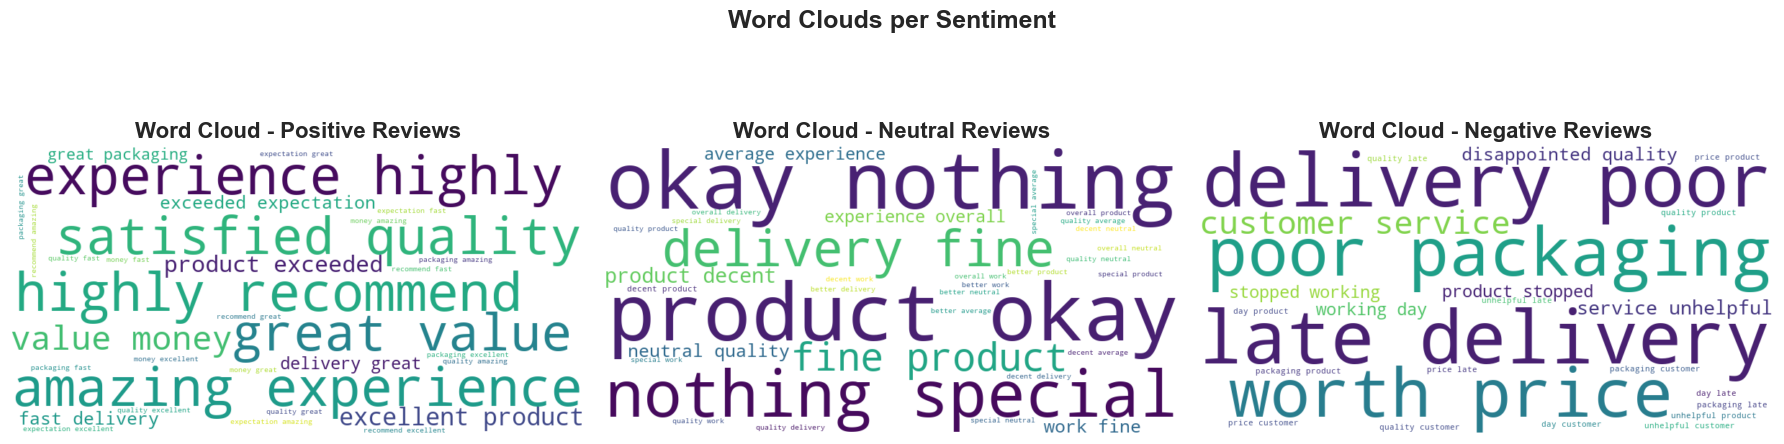

In [12]:
# Create word clouds for each sentiment after preprocessing the review texts
sentiments = ['positive', 'neutral', 'negative']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sentiment in enumerate(sentiments):
    # Get all processed texts for this sentiment
    text = ' '.join(df[df['sentiment_label'] == sentiment]['processed_text'])
    # Generate word cloud
    wordcloud = WordCloud(
        width = 800,
        height = 400,
        background_color = 'white',
        colormap = 'viridis',
        max_words = 100,
        relative_scaling = 0.7,
        min_font_size = 10,
        random_state = 42
    ).generate(text)

    # Plot word cloud
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {sentiment.capitalize()} Reviews', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Word Clouds per Sentiment', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Part 4: Feature Extraction

####  Train-Test Split

In [13]:
# Split data into training and testing sets (80-20 split)
X = df['processed_text']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)
print(f"Training set:{len(X_train):,} reviews")
print(f"Testing set :{len(X_test):,} reviews")

print("\nSentiment Distribution in Training Set:")
print(y_train.value_counts())

print("\nSentiment Distribution in Testing Set:")
print(y_test.value_counts())

Training set:20,000 reviews
Testing set :5,000 reviews

Sentiment Distribution in Training Set:
sentiment_label
positive    7982
negative    7950
neutral     4068
Name: count, dtype: int64

Sentiment Distribution in Testing Set:
sentiment_label
positive    1996
negative    1987
neutral     1017
Name: count, dtype: int64


#### TF-IDF Vectorization

In [14]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2), # Unigrams + Bigrams to capture something like "not good", "very disappointing"
    min_df = 5, # Ignore terms that appear in less than 5 documents
    max_df = 0.9  # Ignore terms that appear in more than 90% of documents
)

# Fit on training data and transform both training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_):,} features")

# Display top features
feature_names = tfidf.get_feature_names_out()
print(f"\nSample features (first 20):")
print(list(feature_names[:20]))

TF-IDF matrix shape (train): (20000, 77)
TF-IDF matrix shape (test): (5000, 77)
Vocabulary size: 77 features

Sample features (first 20):
['amazing', 'amazing experience', 'average', 'average experience', 'better', 'could', 'could better', 'customer', 'customer service', 'day', 'decent', 'delivery', 'delivery fine', 'delivery great', 'delivery poor', 'disappointed', 'disappointed quality', 'exceeded', 'exceeded expectation', 'excellent']


## Part 5: Sentiment Classification Models

### 5.1 Baseline Model (VADER)

In [15]:
# Initialize VADER Sentiment Analyzer
vader = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def vader_sentiment_classify(reviews):
    """To get sentiment predictions using VADER."""
    scores = vader.polarity_scores(reviews)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive', compound
    elif compound <= -0.05:
        return 'negative', compound
    else:
        return 'neutral', compound

# Apply VADER to the original review texts
df[['vader_pred', 'vader_score']] = df['review_text'].apply(
    lambda reviews: pd.Series(vader_sentiment_classify(reviews))
)

# Calculate accuracy
vader_accuracy = accuracy_score(df['sentiment_label'], df['vader_pred'])
print(f"\nVADER Accuracy: {vader_accuracy:.4f} ({vader_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(df['sentiment_label'], df['vader_pred']))



VADER Accuracy: 0.7964 (79.64%)

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.80      0.84      9937
     neutral       0.50      0.39      0.44      5085
    positive       0.83      1.00      0.91      9978

    accuracy                           0.80     25000
   macro avg       0.74      0.73      0.73     25000
weighted avg       0.78      0.80      0.79     25000



> Accuracy is acceptable, positive recall is high, but negative recall is low, indicating VADER struggles with negative reviews in this dataset, may indicate that vader tends to classify neutral as positive/negative

#### Confusion Matrix

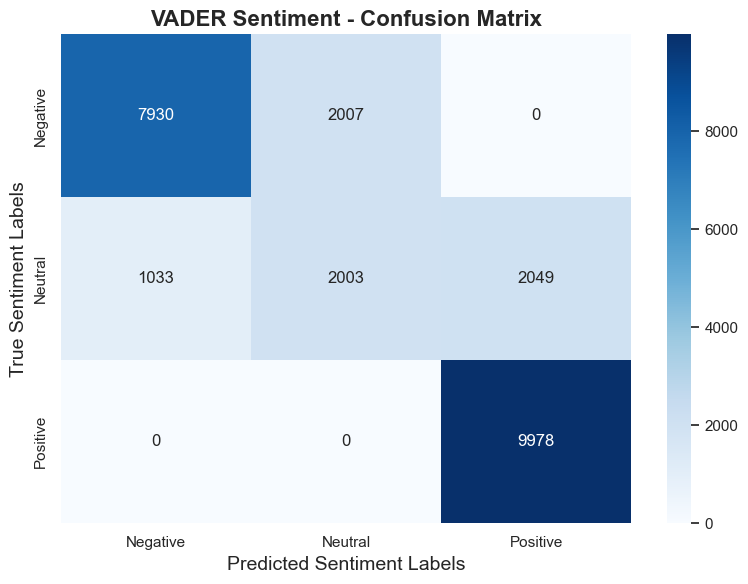

In [16]:
# Confusion Matrix for VADER
cm = confusion_matrix(df['sentiment_label'], df['vader_pred'], labels=['negative', 'neutral', 'positive'])
class_names = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('VADER Sentiment - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Sentiment Labels', fontsize=14)
plt.ylabel('True Sentiment Labels', fontsize=14)
plt.tight_layout()
plt.show()

>The diagonal values represent True Positives (TP) for each class:
>1. **Negative:** 7,930 correctly predicted as negative
>2. **Neutral:** 2,003 correctly predicted as neutral
>3. **Positive:** 9,978 correctly predicted as positive
>4. **Total correct:** 7,930 + 2,003 + 9,978 = 19,911 out of 25,000 reviews
>5. **Accuracy:** 19,911 / 25,000 = 0.79644 or 79.64%
>
> However, neutral reviews were misclassified as positive (2,049) or negative (1,033). However, VADER never confuses positive ↔ negative directly (0 cross-errors), and achieves perfect recall on positive reviews (100%).

### 5.2 Naive Bayes & Logistic Regression Models

#### Train Naive Bayes

In [17]:
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()
# Train the model
nb_model.fit(X_train_tfidf, y_train)

# Predictions
nb_pred = nb_model.predict(X_test_tfidf)

# Evaluation
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"\nNaive Bayes Accuracy: {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1987
     neutral       1.00      1.00      1.00      1017
    positive       1.00      1.00      1.00      1996

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



#### Train Logistic Regression

In [18]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_tfidf)

# Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))


Logistic Regression Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1987
     neutral       1.00      1.00      1.00      1017
    positive       1.00      1.00      1.00      1996

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



#### Confusion Matrices for Both Models

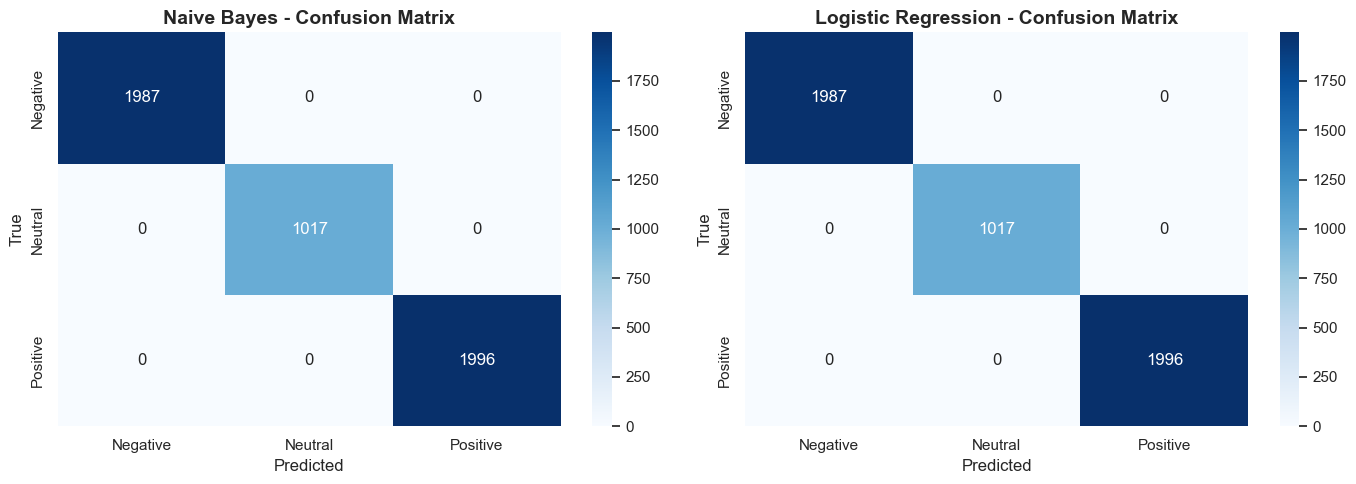

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
class_names = ['Negative', 'Neutral', 'Positive']

# Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

# Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()

> Our interpretation of the confusion matrices: **Naive Bayes & Logistic Regression Models** outperform the rule-based VADER baseline

### 5.3 Transformer Model (BERT)
> **IMPORTANT NOTE:** as I like to work with GPU
>
> If you don't have NVIDIA GPU, this will use CPU (slower but works fine)
> To use GPU, ensure you have the necessary CUDA drivers and PyTorch installed with GPU support.
> If you don't have GPU support, remove the lines that move the model and inputs to the device, as commented in the code below.

In [20]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BERT model and Tokenizer
bert_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name, clean_up_tokenization_spaces=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)
bert_model.to(device)
bert_model.eval()  # Set to evaluation mode

# Function to classify sentiment using BERT
def bert_sentiment_classify(review):
    """Classify sentiment using BERT."""
    inputs = tokenizer(review, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)

    probs = softmax(outputs.logits, dim=-1)
    sentiment_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][sentiment_idx].item()

    # Map 5 stars to 3 categories
    sentiment_map = {
        0: 'negative',   # 1 star
        1: 'negative',   # 2 stars
        2: 'neutral',    # 3 stars
        3: 'positive',   # 4 stars
        4: 'positive'    # 5 stars
    }

    return sentiment_map[sentiment_idx], confidence

# Apply BERT to test set
results = X_test.apply(bert_sentiment_classify)
df_bert_results = pd.DataFrame(results.tolist(), index=X_test.index, columns=['bert_pred', 'bert_confidence'])

# Evaluate
bert_accuracy = accuracy_score(y_test, df_bert_results['bert_pred'])
print(f"\nBERT Accuracy: {bert_accuracy:.4f} ({bert_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, df_bert_results['bert_pred']))


BERT Accuracy: 0.9176 (91.76%)

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1987
     neutral       1.00      0.59      0.75      1017
    positive       0.83      1.00      0.91      1996

    accuracy                           0.92      5000
   macro avg       0.94      0.86      0.88      5000
weighted avg       0.93      0.92      0.91      5000



#### BERT Confusion Matrix

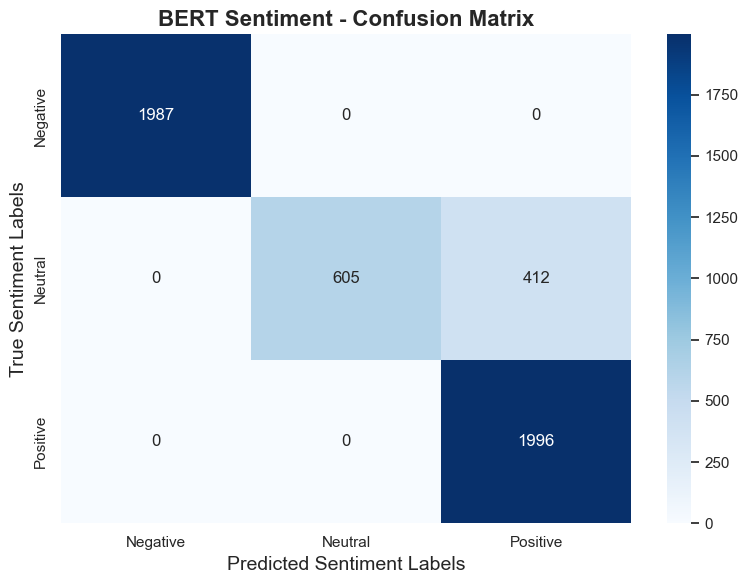

In [21]:
cm_bert = confusion_matrix(y_test, df_bert_results['bert_pred'], labels=['negative', 'neutral', 'positive'])

# Labels name for confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('BERT Sentiment - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Sentiment Labels', fontsize=14)
plt.ylabel('True Sentiment Labels', fontsize=14)
plt.tight_layout()
plt.show()

> **BERT:** worked good on negative (100%) and positive (100%), but struggles with neutral (59%) - misclassifying 412 neutral reviews as positive.
>
> **Compared to VADER:** BERT has fewer errors (412 vs 5,089) and achieves 91.76% accuracy vs VADER's 79.64%.

#### Sentiment Classification - Model Comparison

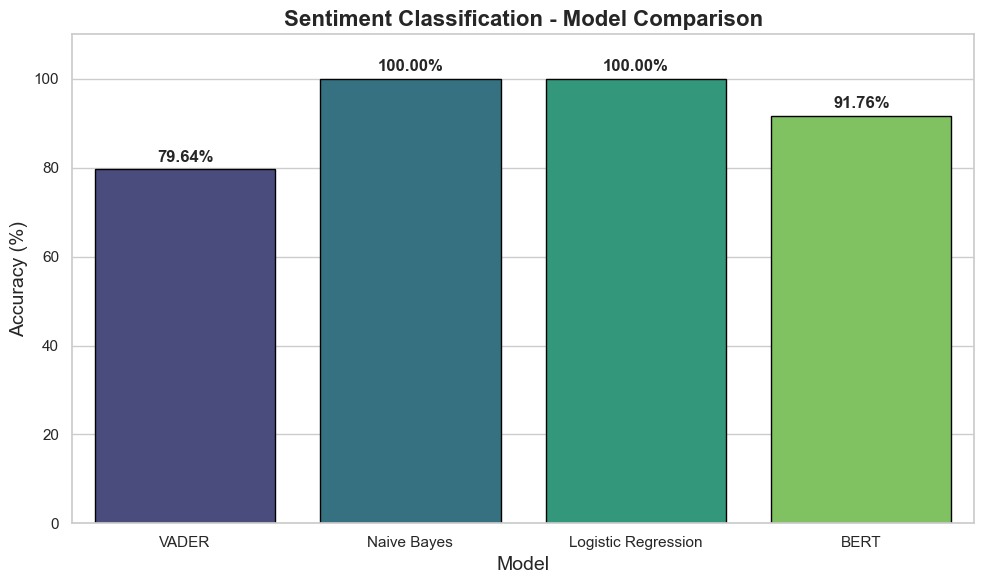

In [22]:
# Model Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Models name for labeling
models = ['VADER', 'Naive Bayes', 'Logistic Regression', 'BERT']

# Models accuracy
accuracies = [vader_accuracy * 100, nb_accuracy * 100, lr_accuracy * 100, bert_accuracy * 100]

sns.barplot(x=models, y=accuracies, palette='viridis', edgecolor='black', ax=ax)

ax.set_ylim(0, 110)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Model', fontsize=14)
ax.set_title('Sentiment Classification - Model Comparison', fontsize=16, fontweight='bold')

# Add value labels on bars
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 1, f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Part 6: Topic Modeling & Feature Analysis

#### LDA Topic Discovery

In [23]:
# LDA with TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1), # Unigrams only for LDA
    stop_words='english', # Remove English stop words
    min_df=10,
    max_df=0.9
)
X_tfidf = tfidf.fit_transform(df['processed_text'])

# Fit LDA model
lda_model = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    n_jobs=-1
)
lda_model.fit(X_tfidf)

# Display topics
print("LDA TOPIC DISCOVERY")
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]] # same as [-10:][::-1]
    print(f"\nTopic {topic_idx + 1}: {', '.join(top_words)}")

LDA TOPIC DISCOVERY

Topic 1: worth, price, experience, highly, amazing, recommend, working, day, stopped, product

Topic 2: fine, decent, work, better, delivery, product, worth, price, overall, average

Topic 3: quality, satisfied, disappointed, neutral, okay, special, product, worth, price, delivery

Topic 4: great, packaging, delivery, value, money, fast, late, poor, product, price

Topic 5: service, customer, unhelpful, excellent, exceeded, expectation, product, worth, price, delivery


> We tried different approaches for Topic modeling, but it seems that the dataset is very poor with vocabulary. We always get mixed topics.

#### Feature-Based Sentiment Analysis

In [24]:
# BERT with the full dataset for feature analysis, I could do it as on GPU, but on CPU it might take time
results_full = df['review_text'].apply(bert_sentiment_classify)
df[['bert_pred_full', 'bert_confidence_full']] = pd.DataFrame(results_full.tolist(), index=df.index)

# Create sentiment scores from BERT predictions
score_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['bert_pred_full'].map(score_map)

print(f"Sentiment scores created for {len(df):,} reviews using BERT")

Sentiment scores created for 25,000 reviews using BERT


In [25]:
# Feature Sentiment Calculation

# Features identified from word clouds
features = ['delivery', 'quality', 'packaging', 'service', 'price', 'value', 'experience']

# Calculate sentiment per feature using BERT scores
feature_sentiment = {feature: [] for feature in features}

for index, row in df.iterrows():
    for feature in features:
        if feature in row['processed_text']:
            feature_sentiment[feature].append(row['sentiment_score'])

# Average sentiment per feature
feature_sentiment_avg = {
    feature: (sum(scores) / len(scores)) if scores else 0
    for feature, scores in feature_sentiment.items()
}
print("Feature-Based Sentiment Analysis (BERT):\n")
print(f"{'Feature':<12} {'Avg Score':<12} {'Count':<10}")
for feature in features:
    avg = feature_sentiment_avg[feature]
    count = len(feature_sentiment[feature])
    print(f"{feature:<12} {avg:>+.2f}         {count:<10}")

Feature-Based Sentiment Analysis (BERT):

Feature      Avg Score    Count     
delivery     +0.19         5023      
quality      +0.01         4952      
packaging    -0.02         3992      
service      -1.00         2007      
price        -1.00         2026      
value        +1.00         1971      
experience   +0.68         3092      


#### Feature Sentiment Analysis Viz

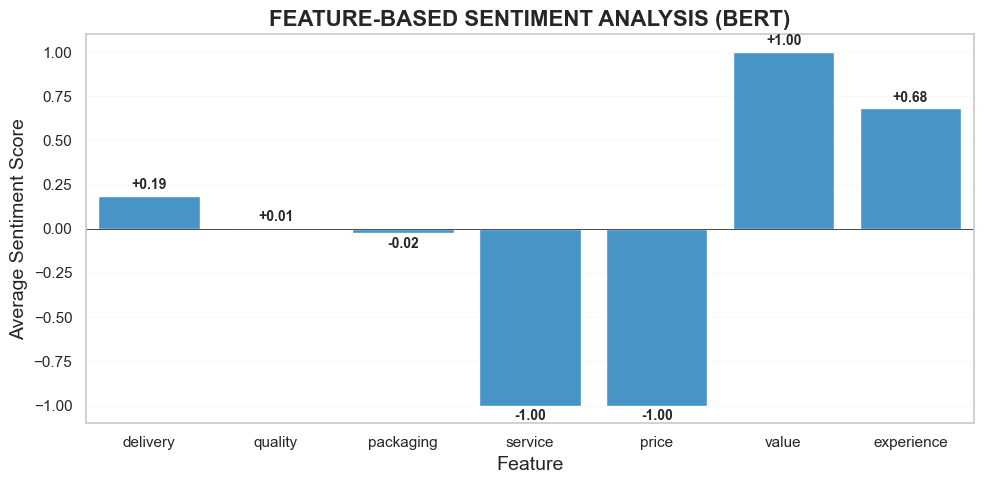

In [26]:
# Feature Sentiment Visualization
fig, ax = plt.subplots(figsize=(10, 5))

features_list = list(feature_sentiment_avg.keys())
scores_list = list(feature_sentiment_avg.values())

# Seaborn barplot
sns.barplot(x=features_list, y=scores_list,  color='#3498db',ax=ax)

# Add value labels
for idx, score in enumerate(scores_list):
    va = 'bottom' if score >= 0 else 'top'
    offset = 0.02 if score >= 0 else -0.02
    ax.text(idx, score + offset, f'{score:+.2f}',
            ha='center', va=va, fontsize=10, fontweight='bold')

ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Average Sentiment Score', fontsize=14)
ax.set_title('FEATURE-BASED SENTIMENT ANALYSIS (BERT)', fontsize=16, fontweight='bold')
ax.axhline(color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.grid(axis='x', visible=False)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

## Part 7: Processed Data Export

In [27]:
# # We decided to export only the following columns:
#
# export_columns = [
#   'customer_id','review_text','processed_text','customer_rating','sentiment_label',
#   'vader_pred','vader_score','bert_pred_full','bert_confidence_full','sentiment_score'
# ]
# # Export processed data to CSV
# df[export_columns].to_csv('../data/processed_customer_sentiment.csv', index=False)
# print("Data export complete!")

## Part 8: Conclusion

> In this notebook, we performed sentiment analysis on customer reviews using various methods:
>
> 1. **VADER**: A rule-based sentiment analysis tool, which provided a baseline accuracy of 79.64%. It struggled with neutral reviews (39% recall).
> 2. **Naive Bayes**: Achieved 100% accuracy due to the dataset's limited vocabulary (15 unique reviews).
> 3. **Logistic Regression**: Similar performance to Naive Bayes with 100% accuracy.
> 4. **BERT**: A transformer-based model that achieved 91.76% accuracy, outperforming VADER but still struggling with neutral reviews (59% recall).
>
> We also explored topic modeling using LDA, but the dataset's vocabulary was limited, leading to mixed topics with overlapping words.
>
> Finally, we conducted feature-based sentiment analysis using BERT, identifying:
> - **Strengths**: Value (+1.00) and Experience (+0.68) drive customer satisfaction
> - **Weaknesses**: Service (-1.00) and Price (-1.00) are major pain points
>
> **Note**: The 100% accuracy of classical ML models (NB, LR) indicates overfitting due to limited vocabulary. For real-world applications with diverse reviews, BERT would likely generalize better.
>
> **Data Note**: The sentiment labels derived from customer ratings (≤2=negative, 3=neutral, ≥4=positive) match the original dataset's sentiment distribution: 40% positive, 40% negative, 20% neutral - a balanced dataset